In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric import nn as gnn

from graph_vae import GraphVAE
from train import train_loop
from data_load import *

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

## Scratchpad

In [3]:
d = torch.randn(10)
d_diag = torch.diag_embed(d)
M = torch.randn(10, 10)

print(torch.all(d.unsqueeze(1)*M == torch.matmul(d_diag, M)))
print(torch.all(M * d == torch.matmul(M, d_diag)))

tensor(True)
tensor(True)


In [6]:
dataset = get_train_dataset()
data_loader = torch.utils.data.DataLoader(dataset, 200, True)

In [18]:
for (X, NL, mask) in data_loader:
    A = eval_A(NL.int())*mask.unsqueeze(2)
    print(X[:, :, -1].max())

tensor(0.8951)
tensor(0.9118)
tensor(0.9004)
tensor(0.8894)
tensor(0.8476)
tensor(0.9631)
tensor(0.8371)
tensor(1.0133)
tensor(0.8952)
tensor(0.9213)
tensor(0.8329)
tensor(0.8558)
tensor(0.9442)
tensor(0.8626)
tensor(0.8884)
tensor(0.9379)
tensor(0.8939)
tensor(0.8558)
tensor(1.1926)
tensor(0.9205)
tensor(0.9311)
tensor(0.8475)
tensor(0.9733)
tensor(1.0340)
tensor(0.8867)
tensor(0.8736)
tensor(0.8699)
tensor(0.9059)
tensor(0.9021)
tensor(0.8803)
tensor(0.8987)
tensor(0.9044)
tensor(1.0155)
tensor(0.9302)
tensor(0.9912)
tensor(1.0871)
tensor(0.9920)
tensor(0.9254)
tensor(0.9718)
tensor(0.9681)
tensor(0.9595)
tensor(0.9228)
tensor(0.8817)
tensor(0.8920)
tensor(0.9043)
tensor(1.0227)
tensor(0.9477)
tensor(0.8980)
tensor(1.2631)
tensor(0.9206)
tensor(0.8822)
tensor(0.8873)
tensor(0.8166)
tensor(0.8116)
tensor(0.9536)
tensor(1.2312)
tensor(0.8409)
tensor(0.9117)
tensor(0.8505)
tensor(0.9070)
tensor(0.9140)
tensor(0.8872)
tensor(0.8432)
tensor(0.9075)
tensor(0.9113)
tensor(0.8508)
tensor(1.0

In [10]:
? torch.min

Docstring:
min(input) -> Tensor

Returns the minimum value of all elements in the :attr:`input` tensor.

.. warning::
    This function produces deterministic (sub)gradients unlike ``min(dim=0)``

Args:
    input (Tensor): the input tensor.

Example::

    >>> a = torch.randn(1, 3)
    >>> a
    tensor([[ 0.6750,  1.0857,  1.7197]])
    >>> torch.min(a)
    tensor(0.6750)

.. function:: min(input, dim, keepdim=False, *, out=None) -> (Tensor, LongTensor)
   :noindex:

Returns a namedtuple ``(values, indices)`` where ``values`` is the minimum
value of each row of the :attr:`input` tensor in the given dimension
:attr:`dim`. And ``indices`` is the index location of each minimum value found
(argmin).

If :attr:`keepdim` is ``True``, the output tensors are of the same size as
:attr:`input` except in the dimension :attr:`dim` where they are of size 1.
Otherwise, :attr:`dim` is squeezed (see :func:`torch.squeeze`), resulting in
the output tensors having 1 fewer dimension than :attr:`input`.

.

## Model Definition and training

In [8]:
net = GraphVAE(400, 3)
# net.load_state_dict(torch.load("Saves/ecal_ep_60_angle.pth"))

Train without cylindrical geometry

In [5]:
loss, E_mse, hit_mse = train_loop(net, 1, 256, 1e-3, device, False)

Epoch : 1 Loss: 0.05923 E mse: 0.00027 Hit mse: 0.00278 L2: 2.58711


Train with cylindrical geometry

In [8]:
loss2, E_mse2, hit_mse2 = train_loop(net, 1, 200, 5e-4, device, True)

Epoch : 1 Loss: 0.05844 E mse: 0.00032 Hit mse: 0.00130 L2: 2.58698


In [28]:
torch.save(net.state_dict(), "Saves/ecal_ep_60_angle.pth")

## Inference and tests

In [3]:
def reconstruct_img3(Y, mask):
    xhit, yhit = Y[:, :, 0]*125, Y[:, :, 1]*125
    val = Y[:, :, 2]/50.
    
    xhit = (xhit % 125).int()
    yhit = (yhit % 125).int()
    
    mask = mask*torch.arange(1, 0, -1./400)**2
    # mask = mask*torch.exp(-torch.arange(400))
    ecal = torch.zeros((Y.shape[0], 125, 125))
    ecal[
        torch.arange(Y.shape[0]).unsqueeze(1),
        xhit,
        yhit
    ] = mask #*val
    
    return ecal

def reconstruct_img2(Y, mask):
    xhit, yhit = (Y[:, :, 0])*125, (Y[:, :, 1])*125
    ener = Y[:, :, 2]/5
    
    xhit = (xhit % 125).int()
    yhit = (yhit % 125).int()
    
    ecal = torch.zeros((Y.shape[0], 125, 125))
    ecal[
        torch.arange(Y.shape[0]).unsqueeze(1),
        xhit,
        yhit
    ] = mask*ener
    
    return ecal

def loss_infer2(net, X, A, mask, periodic=True):
    """
    Inference loss function
    """
    # Reconstructed nodes and edges
    Y, A2, mu, logvar, L1, L2 = net(X, A, mask)
    # Convert back to image
    ecal = reconstruct_img2(Y, mask)
    
    # Make xhits compatible with periodic boundary
    if periodic:
        X_xhit = X[:, :, 0]
        Y_xhit = Y[:, :, 0]
        flag1 = (X_xhit - Y_xhit).abs() > 0.5
        flag2 = X_xhit < 0.5
        
        X_xhit[torch.logical_and(flag1, flag2)] += 1.
        X_xhit[torch.logical_and(flag1, torch.logical_not(flag2))] -= 1.
    else:
        X_xhit = X[:, :, 0]
    
    mse_xhit = torch.nn.MSELoss()(X_xhit, Y[:, :, 0])
    mse_yhit = torch.nn.MSELoss()(X[:, :, 1], Y[:, :, 1])
    mse_hit = mse_xhit + mse_yhit
    
    mse_ener = torch.nn.MSELoss()(X[:, :, 2], Y[:, :, 2])

    return mse_hit, mse_ener, ecal, A2

In [4]:
net = GraphVAE(400, 3)
# net.load_state_dict(torch.load("Saves/ecal_ep_60_angle.pth"))

In [24]:
np.random.randint(5000)

2322

Comparing MSE metrics for different datasets

tensor(0.4029) tensor(0.0013)


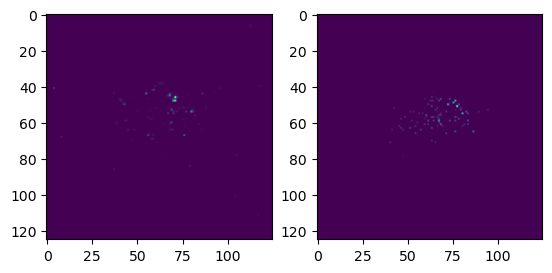

In [36]:
net.load_state_dict(torch.load("Saves/ecal_ep_60_r0.1.pth"))
dataset = get_train_dataset(2500)
data_loader = torch.utils.data.DataLoader(dataset, 2500, True)

for (X, NL, mask) in data_loader:
    X = X
    A = eval_A(NL.int()) * mask.unsqueeze(2)
    mask = mask
    with torch.no_grad():
        # Original samples
        img1 = reconstruct_img2(X, mask)
        # VAE-generated samples
        mse_hit_flat, mse_ener_flat, img2, A2 = loss_infer2(net, X, A, mask, False)
print(mse_hit_flat, mse_ener_flat)

idx = np.random.randint(2500)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1[idx])
ax[1].imshow((img2[idx]+1e-3))
plt.show()
fig.savefig('Report/Plots/Flat_quark_train.pdf')

tensor(0.0914) tensor(0.0004)


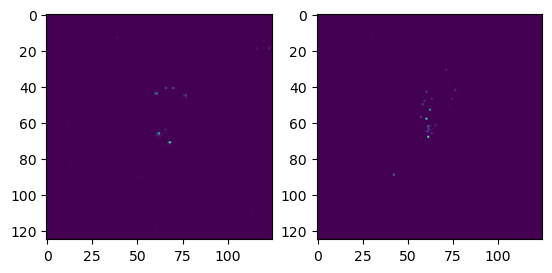

In [37]:
net.load_state_dict(torch.load("Saves/ecal_ep_60_angle.pth"))
dataset = get_train_dataset(2500)
data_loader = torch.utils.data.DataLoader(dataset, 2500, True)

for (X, NL, mask) in data_loader:
    X = X
    A = eval_A(NL.int()) * mask.unsqueeze(2)
    mask = mask
    with torch.no_grad():
        # Original samples
        img1 = reconstruct_img2(X, mask)
        # VAE-generated samples
        mse_hit_angle, mse_ener_angle, img2, A2 = loss_infer2(net, X, A, mask, True)
print(mse_hit_angle, mse_ener_angle)

idx = np.random.randint(2500)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1[idx])
ax[1].imshow((img2[idx]+1e-3))
plt.show()
fig.savefig('Report/Plots/Periodic_quark_train.pdf')

tensor(0.3780) tensor(0.0013)


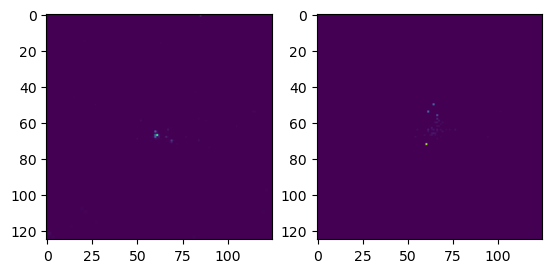

In [38]:
net.load_state_dict(torch.load("Saves/ecal_ep_60_r0.1.pth"))
dataset = get_val_dataset(2500, "quark")
data_loader = torch.utils.data.DataLoader(dataset, 2500, True)

for (X, NL, mask) in data_loader:
    X = X
    A = eval_A(NL.int()) * mask.unsqueeze(2)
    mask = mask
    with torch.no_grad():
        # Original samples
        img1 = reconstruct_img2(X, mask)
        # VAE-generated samples
        mse_hit_flat, mse_ener_flat, img2, A2 = loss_infer2(net, X, A, mask, False)
print(mse_hit_flat, mse_ener_flat)

idx = np.random.randint(2500)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1[idx])
ax[1].imshow((img2[idx]+1e-3))
plt.show()
fig.savefig('Report/Plots/Flat_quark_val.pdf')

tensor(0.0863) tensor(0.0004)


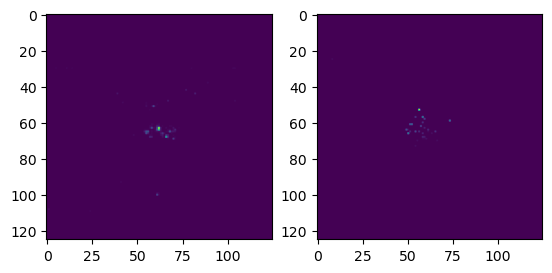

In [39]:
net.load_state_dict(torch.load("Saves/ecal_ep_60_angle.pth"))
dataset = get_val_dataset(2500, "quark")
data_loader = torch.utils.data.DataLoader(dataset, 2500, True)

for (X, NL, mask) in data_loader:
    X = X
    A = eval_A(NL.int()) * mask.unsqueeze(2)
    mask = mask
    with torch.no_grad():
        # Original samples
        img1 = reconstruct_img2(X, mask)
        # VAE-generated samples
        mse_hit_angle, mse_ener_angle, img2, A2 = loss_infer2(net, X, A, mask, True)
print(mse_hit_angle, mse_ener_angle)

idx = np.random.randint(2500)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1[idx])
ax[1].imshow((img2[idx]+1e-3))
plt.show()
fig.savefig('Report/Plots/periodic_quark_val.pdf')

tensor(0.4149) tensor(0.0014)


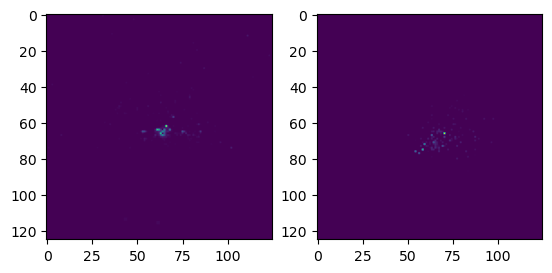

In [40]:
net.load_state_dict(torch.load("Saves/ecal_ep_60_r0.1.pth"))
dataset = get_val_dataset(2500, "gluon")
data_loader = torch.utils.data.DataLoader(dataset, 2500, True)

for (X, NL, mask) in data_loader:
    X = X
    A = eval_A(NL.int()) * mask.unsqueeze(2)
    mask = mask
    with torch.no_grad():
        # Original samples
        img1 = reconstruct_img2(X, mask)
        # VAE-generated samples
        mse_hit_flat, mse_ener_flat, img2, A2 = loss_infer2(net, X, A, mask, False)
print(mse_hit_flat, mse_ener_flat)

idx = np.random.randint(2500)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1[idx])
ax[1].imshow((img2[idx]+1e-3))
plt.show()
fig.savefig('Report/Plots/Flat_gluon_val.pdf')

tensor(0.0943) tensor(0.0005)


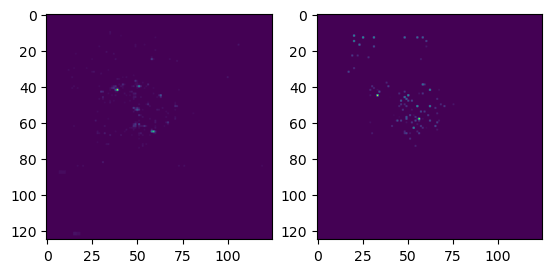

In [41]:
net.load_state_dict(torch.load("Saves/ecal_ep_60_angle.pth"))
dataset = get_val_dataset(2500, "gluon")
data_loader = torch.utils.data.DataLoader(dataset, 2500, True)

for (X, NL, mask) in data_loader:
    X = X
    A = eval_A(NL.int()) * mask.unsqueeze(2)
    mask = mask
    with torch.no_grad():
        # Original samples
        img1 = reconstruct_img2(X, mask)
        # VAE-generated samples
        mse_hit_angle, mse_ener_angle, img2, A2 = loss_infer2(net, X, A, mask, True)
print(mse_hit_angle, mse_ener_angle)

idx = np.random.randint(2500)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1[idx])
ax[1].imshow((img2[idx]+1e-3))
plt.show()
fig.savefig('Report/Plots/periodic_gluon_val.pdf')

In [7]:
img2.max(), img1.max()

(tensor(0.1976), tensor(0.1983))

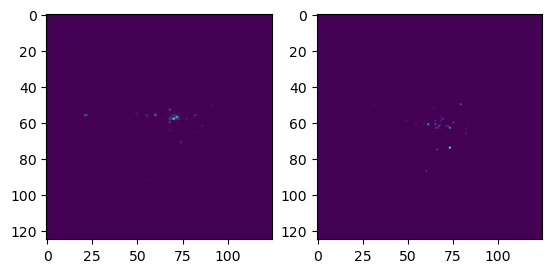

In [8]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1[1])
ax[1].imshow((img2[1]+1e-3))
plt.show()

# plt.savefig('Report/Figures/Gluon_reconstructed.pdf')

## Dataset generation

In [4]:
with h5.File('quark_jets_ecal.h5', 'w') as g:
    f = h5.File('quark-gluon_data-set_n139306.hdf5', 'r')
    
    dset = g.create_dataset('x', shape=(0, 125, 125, 3), dtype=np.float32,
                            maxshape=(None, 125, 125, 3))
    L = 100_000
    w = 10_000

    for i in range(10):
        x, y = f['X_jets'][i*w: (i+1)*w], f['y'][i*w: (i+1)*w]
        x, y = torch.from_numpy(x), torch.from_numpy(y)
        (ind_0,) = torch.nonzero(y==0, as_tuple=True)
        x = x[ind_0]
        curr_shape = dset.shape[0]
        dset.resize((curr_shape+x.shape[0], 125, 125, 3))
        dset[curr_shape:, :, :] = x
    print(dset.shape[0])
    f.close()

50000


Generate validation dataset

In [5]:
with h5.File('gluon_val_graph_ecal.h5', 'w') as h:
    f = h5.File('quark-gluon_data-set_n139306.hdf5', 'r')
    X_dset = h.create_dataset('X', shape=(0, 400, 3), dtype=np.float32,
                            maxshape=(None, 400, 3), compression="gzip")
    NL_dset = h.create_dataset('NL', shape=(0, 400, 6), dtype=np.float32,
                        maxshape=(None, 400, 6), compression="gzip")
    mask_dset = h.create_dataset('mask', shape=(0, 400), dtype=np.float32,
                        maxshape=(None, 400), compression="gzip")
    L = 100_000
    w = 5_000

    for i in range(5):
        x, y = f['X_jets'][L+(i-1)*w: L+i*w, :, :, 1], f['y'][L+(i-1)*w: L+i*w]
        x, y = torch.from_numpy(x), torch.from_numpy(y)
        (ind_0,) = torch.nonzero(y==1, as_tuple=True)
        x = x[ind_0]
        
        x[x < 1e-3] = 0
        x[x > 0.2] = 0
        
        X, A, mask, _ = preprocess(x, "cpu")
        NL = torch.argsort(A, 1, True)[:, :6, :].int().permute(0, 2, 1)
        
        X[:, :, :2] = X[:, :, :2]/125 # Pixels in (0, 1) range
        X[:, :, 2] = X[:, :, 2]*5 # Energies in (0, 1) range
        
        curr_shape = X_dset.shape[0]
        X_dset.resize((curr_shape+X.shape[0], 400, 3))
        NL_dset.resize((curr_shape+X.shape[0], 400, 6))
        mask_dset.resize((curr_shape+X.shape[0], 400))
        
        X_dset[curr_shape:, :, :] = X.to("cpu").numpy()
        NL_dset[curr_shape:, :, :] = NL.to("cpu").numpy()
        mask_dset[curr_shape:, :] = mask.float().to("cpu").numpy()
    f.close()

In [9]:
with h5.File('gluon_val_graph_ecal.h5') as h:
    print(h['X'].shape[0])

12501


This generates a 3-channel heavy-duty dataset

In [2]:
# with h5.File('quark_jets_ecal.h5') as g:
#     with h5.File('quark_3chan_graph.h5', 'w') as h:
#         X_dset = h.create_dataset('X', shape=(0, 1000, 4), dtype=np.float32,
#                             maxshape=(None, 1000, 4))
#         A_dset = h.create_dataset('A', shape=(0, 1000, 1000), dtype=np.float32,
#                             maxshape=(None, 1000, 1000))
#         mask_dset = h.create_dataset('mask', shape=(0, 1000), dtype=np.float32,
#                             maxshape=(None, 1000))
        
#         device = torch.device("cpu")
#         w = 2000
#         for i in range(25):
#             x = g['x'][i*w: (i+1)*w]
#             x = torch.from_numpy(x).to(device)
#             X, A, mask, _ = preprocess(x, device)
            
#             curr_shape = X_dset.shape[0]
                
#             X_dset.resize((curr_shape+w, 1000, 4))
#             A_dset.resize((curr_shape+w, 1000, 1000))
#             mask_dset.resize((curr_shape+w, 1000))
            
#             X_dset[curr_shape:, :, :] = X.to("cpu").numpy()
#             A_dset[curr_shape:, :, :] = A.to("cpu").numpy()
#             mask_dset[curr_shape:, :] = mask.to("cpu").numpy()

This generates a smaller single channel dataset

In [6]:
with h5.File('quark_jets_ecal.h5') as g:
    with h5.File('quark_ecal_graph.h5', 'w') as h:
        X_dset = h.create_dataset('X', shape=(0, 400, 3), dtype=np.float32,
                            maxshape=(None, 400, 3), compression="gzip")
        NL_dset = h.create_dataset('NL', shape=(0, 400, 6), dtype=np.float32,
                            maxshape=(None, 400, 6), compression="gzip")
        mask_dset = h.create_dataset('mask', shape=(0, 400), dtype=np.float32,
                            maxshape=(None, 400), compression="gzip")
        
        device = "cpu"
        w = 2000
        for i in range(25):
            x = g['x'][i*w: (i+1)*w]
            x = torch.from_numpy(x)[:, :, :, 1].to(device)
            # Exclude energies that are too low or high
            x[x < 1e-3] = 0
            x[x > 0.2] = 0
            
            X, A, mask, _ = preprocess(x, device)
            
            NL = torch.argsort(A, 1, True)[:, :6, :].int().permute(0, 2, 1)
            
            curr_shape = X_dset.shape[0]
            X_dset.resize((curr_shape+w, 400, 3))
            NL_dset.resize((curr_shape+w, 400, 6))
            mask_dset.resize((curr_shape+w, 400))
            
            X_dset[curr_shape:, :, :] = X.to("cpu").numpy()
            NL_dset[curr_shape:, :, :] = NL.to("cpu").numpy()
            mask_dset[curr_shape:, :] = mask.float().to("cpu").numpy()
            

In [16]:
# Check minimum and maximum energies
with h5.File('quark_ecal_graph_normalized.h5') as g:
    device = "cpu"
    w = 10_000
    # bins = np.linspace(-6.908, 1.4125, 12)
    # hist = np.zeros(bins.shape[0] - 1)
    for i in range(5):
        X = g['X'][i*w: (i+1)*w]
        mask = torch.from_numpy(g['mask'][i*w: (i+1)*w])
        counts = mask.sum(1).int()
        # Studying the typical energies
        E_hit = torch.from_numpy(X[:, :, 2])
        X_hit = torch.from_numpy(X[:, :, :2])
        # log_E_hit = torch.nan_to_num(torch.log(E_hit), neginf=0.)
        
        # log_E_hit_mean = (log_E_hit.sum(1)/counts).unsqueeze(1)
        # # print(log_E_hit.shape, log_E_hit_mean.shape, mask.shape)
        # log_E_hit_var = (((log_E_hit - log_E_hit_mean)*mask)**2).sum(1)/counts
        
        # print("Mean log_E: ", log_E_hit_mean.mean(), 
        #       "Std log_E: ", log_E_hit_var.sqrt().mean())
        print(E_hit.max(), E_hit.min())
        # for j in range(w):
        #     hist += np.histogram(log_E_hit[j, :counts[j]], bins)[0]

tensor(0.9997) tensor(0.)
tensor(0.9999) tensor(0.)
tensor(0.9999) tensor(0.)
tensor(0.9999) tensor(0.)
tensor(0.9997) tensor(0.)


In [21]:
print(bins[-7:])
print(hist[-6:])

[-3.12595455 -2.36954545 -1.61313636 -0.85672727 -0.10031818  0.65609091
  1.4125    ]
[7.1894e+04 2.3778e+04 5.4970e+03 7.7800e+02 6.2000e+01 1.9000e+01]


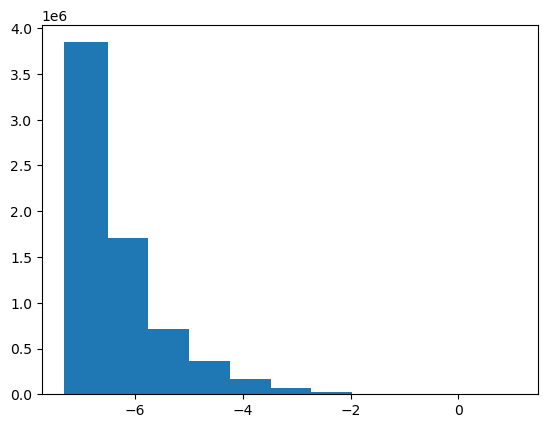

In [15]:
# Plotting the histogram of log energies
plt.bar(bins[:-1], hist)
plt.show()

In [13]:
print(0.5*(np.log(1.4) + np.log(1e-3)))
print(0.5*(np.log(1.4) - np.log(1e-3)))

-3.285641521180462
3.622113757801675


In [7]:
with h5.File('quark_ecal_graph.h5') as g:
    with h5.File('quark_ecal_graph_normalized.h5', 'w') as h:
        X_dset = h.create_dataset('X', shape=(0, 400, 3), dtype=np.float32,
                            maxshape=(None, 400, 3), compression="gzip")
        NL_dset = h.create_dataset('NL', shape=(0, 400, 6), dtype=np.float32,
                            maxshape=(None, 400, 6), compression="gzip")
        mask_dset = h.create_dataset('mask', shape=(0, 400), dtype=np.float32,
                            maxshape=(None, 400), compression="gzip")
        
        device = "cpu"
        w = 2000
        for i in range(25):
            X = g['X'][i*w: (i+1)*w]
            NL = g['NL'][i*w: (i+1)*w]
            mask = g['mask'][i*w: (i+1)*w]
            
            X = torch.from_numpy(X)
            X[:, :, :2] = X[:, :, :2]/125 # Pixels in (0, 1) range
            X[:, :, 2] = X[:, :, 2]*5 # Energies in (0, 1) range
            
            curr_shape = X_dset.shape[0]
            
            X_dset.resize((curr_shape+w, 400, 3))
            NL_dset.resize((curr_shape+w, 400, 6))
            mask_dset.resize((curr_shape+w, 400))
            
            X_dset[curr_shape:, :, :] = X.to("cpu").numpy()
            NL_dset[curr_shape:, :, :] = NL
            mask_dset[curr_shape:, :] = mask
            

In [2]:
dataset = get_train_dataset()